# English Premiership League 2020/21 Table and Data Visualization

## Import Required Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt # plotting library
import seaborn as sns # high-level visualization library

# suppress warnings,,,
import warnings
warnings.filterwarnings('ignore')

## Get file path

In [2]:
file = ""
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file = os.path.join(dirname, filename)

## Read Data

In [3]:
data = pd.read_excel(file)

In [4]:
data.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,2020-09-12,12:30:00,Fulham,Arsenal,0,3,A,0,1,...,1.84,0.75,2.01,1.89,2.02,1.91,2.13,1.92,2.02,1.87
1,E0,2020-09-12,15:00:00,Crystal Palace,Southampton,1,0,H,1,0,...,1.70,0.25,1.78,2.13,1.79,2.17,1.85,2.18,1.79,2.12
2,E0,2020-09-12,17:30:00,Liverpool,Leeds,4,3,H,3,2,...,2.62,-1.50,1.85,2.05,1.85,2.08,1.90,2.16,1.84,2.04
3,E0,2020-09-12,20:00:00,West Ham,Newcastle,0,2,A,0,0,...,1.92,-0.50,2.03,1.87,2.04,1.88,2.09,1.91,2.02,1.86
4,E0,2020-09-13,14:00:00,West Brom,Leicester,0,3,A,0,0,...,1.73,0.25,1.92,1.98,1.93,1.99,1.95,2.01,1.91,1.97


## Exploratory Data Analysis

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Columns: 106 entries, Div to AvgCAHA
dtypes: datetime64[ns](1), float64(82), int64(16), object(7)
memory usage: 314.8+ KB


## Choose Relevant Columns for Analysis

In [6]:
# choose required columns
select_columns = data.columns[3:7]
select_columns

Index(['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG'], dtype='object')

In [7]:
new_data = data[select_columns]
new_data.head()

,HomeTeam,AwayTeam,FTHG,FTAG
0,Fulham,Arsenal,0,3
1,Crystal Palace,Southampton,1,0
2,Liverpool,Leeds,4,3
3,West Ham,Newcastle,0,2
4,West Brom,Leicester,0,3


In [8]:
# Function to get points won by home and away teams
def get_points(row, key: str):
    """
    `row`: each record/row of the data frame
    `key`: return key of the
    """
    MAX_POINTS = 3
    results = {}
    home_goals, away_goals = row["FTHG"], row["FTAG"] #unpack home and away goals columns
    results['home'] = 1
    results['away'] = 1
    results['game_status'] = "Draw"
    results['win_team'] = [row['HomeTeam'], row['AwayTeam']]
    if home_goals != away_goals:
        results['game_status'] = "Win"
    if home_goals > away_goals:
        results['home'] = MAX_POINTS
        results['win_team'] = row['HomeTeam']
        results['away'] = 0
    elif away_goals > home_goals:
        results['away'] = MAX_POINTS
        results['win_team'] = row['AwayTeam']
        results['home'] = 0
    return results[key]

In [9]:
# Add Helper columns to table
new_data["Win_Team"] = new_data.apply(lambda x: get_points(x, 'win_team'), axis=1) #The winning club
new_data["Game_Status"] = new_data.apply(lambda x: get_points(x, 'game_status'), axis=1) # return Win or Draw
new_data['HomePoints'] = new_data.apply(lambda x: get_points(x, 'home'), axis=1) # Points won by the Home Team
new_data["AwayPoints"] = new_data.apply(lambda x: get_points(x, 'away'), axis=1) # Points won by the Away Team
new_data.head() # inspect data frame

,HomeTeam,AwayTeam,FTHG,FTAG,Win_Team,Game_Status,HomePoints,AwayPoints
0,Fulham,Arsenal,0,3,Arsenal,Win,0,3
1,Crystal Palace,Southampton,1,0,Crystal Palace,Win,3,0
2,Liverpool,Leeds,4,3,Liverpool,Win,3,0
3,West Ham,Newcastle,0,2,Newcastle,Win,0,3
4,West Brom,Leicester,0,3,Leicester,Win,0,3


In [10]:
# Get featured data frame of a chosen team
def get_featured_games(team: str):
    """
    returns dataframe of games played by a chosen team
    `team`: name of team
    """
    return new_data[(new_data['HomeTeam'] == team) + (new_data['AwayTeam'] == team)]

In [11]:
# Get win, loss and draw counts for a team
def get_win_loss_draw_count(team: str, game_status: str):
    result = []
    df_team_featured =  get_featured_games(team)
    if game_status == 'Win':
        result = df_team_featured[(df_team_featured['Game_Status'] == game_status) *
                                  (df_team_featured['Win_Team'] == team)]
    elif game_status == 'Loss':
        result = df_team_featured[(df_team_featured['Game_Status'] != 'Draw') *
                                  (df_team_featured['Win_Team'] != team)]
    elif game_status == 'Draw':
        result = df_team_featured[(df_team_featured['Game_Status'] == 'Draw') *
                                  (df_team_featured['Win_Team'] != team)]

    return len(result)

In [12]:
def get_goals_scored(team: str, case_: str):
  # team = 'Arsenal'
  # case_ = 'GF'
  result = None
  df = get_featured_games(team)
  if case_ == 'GF':
    home_goals = df[df['HomeTeam'] == team]['FTHG'].sum()
    away_goals = df[df['AwayTeam'] == team]['FTAG'].sum()
    result = home_goals + away_goals
  elif case_ == 'GA':
    home_goals_against = df[df['HomeTeam'] == team]['FTAG'].sum()
    away_goals_against = df[df['AwayTeam'] == team]['FTHG'].sum()
    result = home_goals_against + away_goals_against

  return result

In [13]:
def get_total_points_earned(team: str):
  df = get_featured_games(team)
  df_win = df[df['Win_Team'] == team]
  win_points = df_win['HomePoints'] + df_win['AwayPoints']

  df_draw = df[df['Game_Status'] == 'Draw']
  draw_points = df_draw['HomePoints']

  return win_points.sum() + draw_points.sum()

## Get combination of team play home and away

In [14]:
clubs = pd.concat([new_data['HomeTeam'], new_data['AwayTeam']], axis=0)

## 1. Generate a league table with columns for Club, Played, Won, Drawn, Lost, GF, GA, GD, Points as you would see in a typical English Premier League Table

In [15]:
table = pd.DataFrame(zip(clubs.value_counts().index,
                         clubs.value_counts().values), columns=['club', 'played'])

# Add other columns as placeholders
other_columns = ["Won", "Drawn", "Lost", "GF", "GA", "GD", "Points"]
for col in other_columns:
    table[col] = 0

table['Won'] = table.apply(lambda x: get_win_loss_draw_count(x['club'], 'Win'), axis=1)
table['Drawn'] = table.apply(lambda x: get_win_loss_draw_count(x['club'], 'Draw'), axis=1)
table['Lost'] = table.apply(lambda x: get_win_loss_draw_count(x['club'], 'Loss'), axis=1)
table['GF'] = table.apply(lambda x: get_goals_scored(x['club'], 'GF'), axis=1)
table['GA'] = table.apply(lambda x: get_goals_scored(x['club'], 'GA'), axis=1)
table['GD'] = table['GF'] - table['GA']
table['Points'] = table.apply(lambda x: get_total_points_earned(x['club']), axis=1)
table.sort_values(by="Points", ascending=False, inplace=True)
table.reset_index(inplace=True)
table.drop(columns=['index'], axis=1, inplace=True)
table

,club,played,Won,Drawn,Lost,GF,GA,GD,Points
0,Man City,38,27,5,6,83,32,51,86
1,Man United,38,21,11,6,73,44,29,74
2,Liverpool,38,20,9,9,68,42,26,69
3,Chelsea,38,19,10,9,58,36,22,67
4,Leicester,38,20,6,12,68,50,18,66
5,West Ham,38,19,8,11,62,47,15,65
6,Tottenham,38,18,8,12,68,45,23,62
7,Arsenal,38,18,7,13,55,39,16,61
8,Leeds,38,18,5,15,62,54,8,59
9,Everton,38,17,8,13,47,48,-1,59


## 2. Create a bar chart of Total Points Earned (Points) sorted in descending order

In [16]:
def plot_bar(x: str, title: str, x_label: str, y_label: str="Clubs", y: str='club', data_=table):
    ax = sns.barplot(data=data_, x=x, y=y)
    ax.set(title=title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()

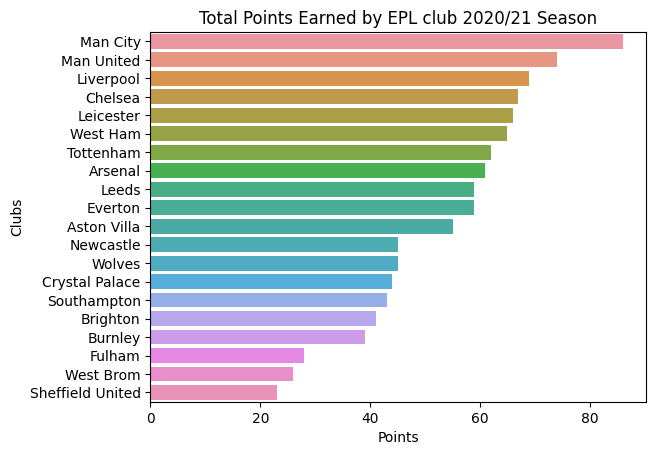

In [17]:
plot_bar('Points', 'Total Points Earned by EPL club 2020/21 Season', 'Points')

## 3. Create a bar chart of Total Goals scored in favour (GF) sorted in descending order

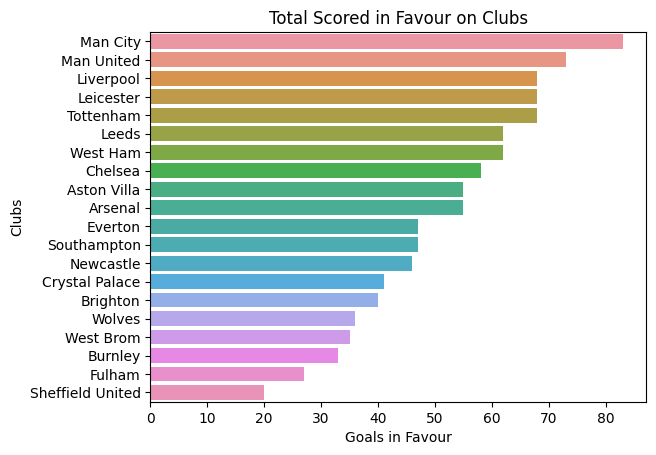

In [18]:
plot_bar('GF', "Total Scored in Favour on Clubs", "Goals in Favour", data_=table.sort_values(by='GF', ascending=False))

## 4. Create a bar chart of Total Goals scored against (GA) sorted in descending order

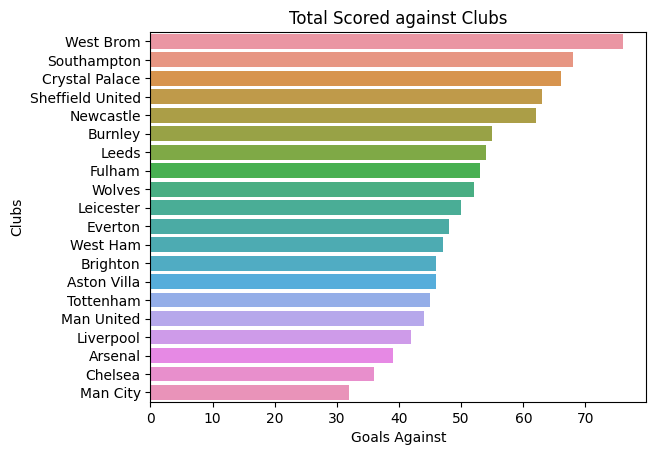

In [19]:
plot_bar('GA', "Total Scored against Clubs", "Goals Against", data_=table.sort_values(by='GA', ascending=False))

## 5. Create a bar chart of Total Goals Difference (GD) sorted in descending order

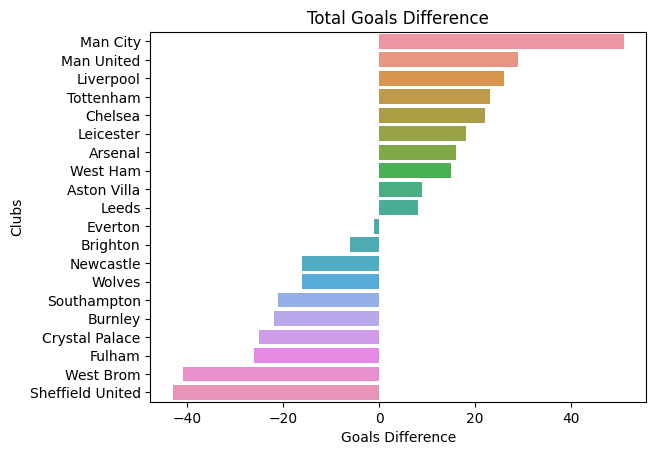

In [20]:
plot_bar('GD', "Total Goals Difference", "Goals Difference", data_=table.sort_values(by='GD', ascending=False))